In [21]:
!git clone https://github.com/oasysokubo/Track.ai.git

fatal: destination path 'Track.ai' already exists and is not an empty directory.


In [22]:
!ls Track.ai

driving_log.csv  IMG


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
import cv2
import pandas as pd
import random
import ntpath

In [24]:
datadir = 'Track.ai'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\center_2019_10_17_19_13_59_202.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\left_2019_10_17_19_13_59_202.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\right_2019_10_17_19_13_59_202.jpg,0.0,0.0,0.0,0.000082
1,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\center_2019_10_17_19_13_59_314.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\left_2019_10_17_19_13_59_314.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\right_2019_10_17_19_13_59_314.jpg,0.0,0.0,0.0,0.000078
2,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\center_2019_10_17_19_13_59_422.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\left_2019_10_17_19_13_59_422.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\right_2019_10_17_19_13_59_422.jpg,0.0,0.0,0.0,0.000081
3,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\center_2019_10_17_19_13_59_531.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\left_2019_10_17_19_13_59_531.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\right_2019_10_17_19_13_59_531.jpg,0.0,0.0,0.0,0.000080
4,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\center_2019_10_17_19_13_59_635.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\left_2019_10_17_19_13_59_635.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\right_2019_10_17_19_13_59_635.jpg,0.0,0.0,0.0,0.000079


In [25]:
# Imit the local directory from the name of file

def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_10_17_19_13_59_202.jpg,left_2019_10_17_19_13_59_202.jpg,right_2019_10_17_19_13_59_202.jpg,0.0,0.0,0.0,0.000082
1,center_2019_10_17_19_13_59_314.jpg,left_2019_10_17_19_13_59_314.jpg,right_2019_10_17_19_13_59_314.jpg,0.0,0.0,0.0,0.000078
2,center_2019_10_17_19_13_59_422.jpg,left_2019_10_17_19_13_59_422.jpg,right_2019_10_17_19_13_59_422.jpg,0.0,0.0,0.0,0.000081
3,center_2019_10_17_19_13_59_531.jpg,left_2019_10_17_19_13_59_531.jpg,right_2019_10_17_19_13_59_531.jpg,0.0,0.0,0.0,0.000080
4,center_2019_10_17_19_13_59_635.jpg,left_2019_10_17_19_13_59_635.jpg,right_2019_10_17_19_13_59_635.jpg,0.0,0.0,0.0,0.000079


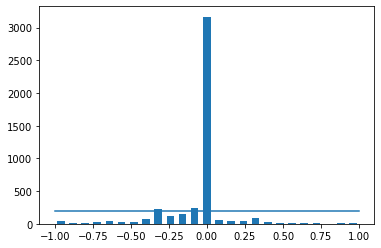

In [26]:
# Plot steering wheels to visualize distribution, see which way is more frequent 

num_bins = 25 # Odd number to attain center of distribution
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 4508
removed: 3033
remaining 1475


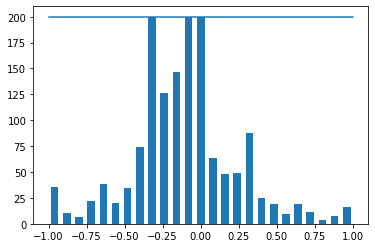

In [27]:
# Flatten data distribution of above data to prevent bias towards centerization
# Uniform our data
# Specify the samples we want to remove
print('total data:', len(data))

remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    # If steering angle falls between two bins, then it belongs to the current interval bin j thats being iterated through
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i) # Point to the steering angle i
  list_ = shuffle(list_) # 
  list_ = list_[samples_per_bin:] # Isolate the indices that go beyond the threshold
  remove_list.extend(list_)
  
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remaining', len(data))

# Now we have data which cuts of extraneous samples for specific bins whose frequency exceeds 200
# making our data more uniform and less bias

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

"""
The output is a distribution of steering angles that are much more uniform, viewed data in relative proportion
There are significant left and right steering angles, eliminating the extreme bias to driving straight all the time
This extreme bias resulted from the training as we drove the car as smooth as possible in the middle of the road, and thereby, recording the 
ideal steering angle at all times

We fix this by cropping most of the extraneous training data

Alternate Solution:
Let the car continuously steer in either direction drifting to the edge of the road, but not actually hitting the edges
and have it recover back to the middle before it crashes
Because simply driving down the middle of the road and recording that, is not enough to train model to drive properly

Imagine the car wanders off to the side of the road in such a case it wouldn't be able to recover back
to the middle as it wouldn't be able to predict the appropriate left steering measurements therefore
an alternative to manipulating the data in this way is to record a recovery laps where we actually make
a separate recording of the car constantly steering back from the sides.

So what you would do is turn off the recording of the car or wandering off to the side since that's
not the behavior that we want to train the model on but only record once we're going to steer back to
the middle.

And now since having gotten rid of the zero angle bias not completely since we still want our car
to favor driving down the middle let's load our image and steering data into arrays so we're able to
manipulate them and split them into training and validation data.

"""